# NLP in Pyspark's MLlib Project

## Fake Job Posting Predictions

Indeed.com has just hired you to create a system that automatically flags suspicious job postings on it's website. It has recently seen an influx of fake job postings that is negativley impacting it's customer experience. Becuase of the high volume of job postings it receives everyday, their employees do have the capacity to check every posting so they would like prioritize which postings to review before deleting it. 

#### Your task
Use the attached dataset with NLP to create an alogorthim which automatically flags suspicious posts for review. 

#### The data
This dataset contains 18K job descriptions out of which about 800 are fake. The data consists of both textual information and meta-information about the jobs.

**Data Source:** https://www.kaggle.com/shivamb/real-or-fake-fake-jobposting-prediction

#### Have fun!

In [1]:
# First let's create our PySpark instance
# import findspark
# findspark.init()

import pyspark # only run after findspark.init()
from pyspark.sql import SparkSession
# May take awhile locally
spark = SparkSession.builder.appName("NLP").getOrCreate()

cores = spark._jsc.sc().getExecutorMemoryStatus().keySet().size()
print("You are working with", cores, "core(s)")
spark

You are working with 1 core(s)


In [2]:
from pyspark.ml.feature import * #CountVectorizer,StringIndexer, RegexTokenizer,StopWordsRemover
from pyspark.sql.functions import * #col, udf,regexp_replace,isnull
from pyspark.sql.types import * #StringType,IntegerType
from pyspark.ml.classification import *
from pyspark.ml.evaluation import *
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# For pipeline development
from pyspark.ml import Pipeline 

In [3]:
path ="Datasets/"

# CSV
df = spark.read.csv(path+'fake_job_postings.csv',inferSchema=True,header=True)

In [4]:
df.limit(4).toPandas()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,None,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,None,0,1,0,Other,Internship,None,None,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,None,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,None,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",None,None,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,None,0,1,0,None,None,None,None,None,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,None,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0


In [5]:
df.filter(col('fraudulent') == 1).show(5)

+------+--------------------+-----------------+--------------------+------------+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+-------------+---------------+--------------------+--------------------+--------------------+--------+----------+
|job_id|               title|         location|          department|salary_range|     company_profile|         description|        requirements|            benefits|telecommuting|    has_company_logo|has_questions|employment_type| required_experience|  required_education|            industry|function|fraudulent|
+------+--------------------+-----------------+--------------------+------------+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+-------------+---------------+--------------------+--------------------+--------------------+--------+----------+
|    66|   Digital Developer|  NZ, N, Auckland|           

In [6]:
df.printSchema()

root
 |-- job_id: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- location: string (nullable = true)
 |-- department: string (nullable = true)
 |-- salary_range: string (nullable = true)
 |-- company_profile: string (nullable = true)
 |-- description: string (nullable = true)
 |-- requirements: string (nullable = true)
 |-- benefits: string (nullable = true)
 |-- telecommuting: string (nullable = true)
 |-- has_company_logo: string (nullable = true)
 |-- has_questions: string (nullable = true)
 |-- employment_type: string (nullable = true)
 |-- required_experience: string (nullable = true)
 |-- required_education: string (nullable = true)
 |-- industry: string (nullable = true)
 |-- function: string (nullable = true)
 |-- fraudulent: string (nullable = true)



In [7]:
df.count()

17880

In [8]:
from pyspark.sql.functions import *

def null_value_calc(df):
    null_columns_counts = []
    numRows = df.count()
    for k in df.columns:
        nullRows = df.where(col(k).isNull()).count()
        if(nullRows > 0):
            temp = k,nullRows,(nullRows/numRows)*100
            null_columns_counts.append(temp)
    return(null_columns_counts)

null_columns_calc_list = null_value_calc(df)
spark.createDataFrame(null_columns_calc_list, ['Column_Name', 'Null_Values_Count','Null_Value_Percent']).show()

+-------------------+-----------------+--------------------+
|        Column_Name|Null_Values_Count|  Null_Value_Percent|
+-------------------+-----------------+--------------------+
|           location|              346|  1.9351230425055927|
|         department|            11547|   64.58053691275167|
|       salary_range|            15011|   83.95413870246085|
|    company_profile|             3308|  18.501118568232663|
|        description|                1|0.005592841163310962|
|       requirements|             2573|  14.390380313199106|
|           benefits|             6966|   38.95973154362416|
|      telecommuting|               89| 0.49776286353467564|
|   has_company_logo|               29|  0.1621923937360179|
|      has_questions|               30| 0.16778523489932887|
|    employment_type|             3292|   18.41163310961969|
|required_experience|             6723|  37.600671140939596|
| required_education|             7748|  43.333333333333336|
|           industry|   

In [9]:
# Of course you will want to know how many rows that affected before you actually execute it..
og_len = df.count()
drop_len = df.na.drop().count()
print("Total Rows that contain at least one null value:",og_len-drop_len)
print("Percentage of Rows that contain at least one null value:", (og_len-drop_len)/og_len)

Total Rows that contain at least one null value: 17094
Percentage of Rows that contain at least one null value: 0.9560402684563758


In [10]:
df= df.select(df.columns[1:])

### Note: Replace null values with something

In [11]:
# I decided to repalce null values with the string "empty" 
df = df.fillna('empty')

In [12]:
df.show(5)

+--------------------+------------------+----------+------------+--------------------+--------------------+--------------------+--------------------+-------------+----------------+-------------+---------------+-------------------+------------------+--------------------+--------------------+----------+
|               title|          location|department|salary_range|     company_profile|         description|        requirements|            benefits|telecommuting|has_company_logo|has_questions|employment_type|required_experience|required_education|            industry|            function|fraudulent|
+--------------------+------------------+----------+------------+--------------------+--------------------+--------------------+--------------------+-------------+----------------+-------------+---------------+-------------------+------------------+--------------------+--------------------+----------+
|    Marketing Intern|  US, NY, New York| Marketing|       empty|We're Food52, and...|Food5

In [13]:
df.columns[-1]

'fraudulent'

In [14]:
# Quick data quality check on the state column....
# This is going to be our category column so it's important
df.groupBy("fraudulent").count().orderBy(col("count").desc()).show()

+--------------------+-----+
|          fraudulent|count|
+--------------------+-----+
|                   0|16080|
|                   1|  886|
|               empty|  176|
|           Full-time|   73|
|Hospital & Health...|   55|
|   Bachelor's Degree|   53|
|         Engineering|   26|
| perform quality ...|   17|
|         Unspecified|   15|
|    Mid-Senior level|   15|
|               Sales|   14|
|           Associate|   14|
|Information Techn...|   13|
|           Marketing|   13|
| passionate about...|   13|
|            Internet|   12|
|   Computer Software|   12|
|      Not Applicable|   11|
|We offer an excel...|   11|
| además con el fi...|   10|
+--------------------+-----+
only showing top 20 rows



In [15]:
df = df.filter("fraudulent IN('0','1')")
# Make sure it worked
df.groupBy("fraudulent").count().orderBy(col("count").desc()).show(truncate=False)

+----------+-----+
|fraudulent|count|
+----------+-----+
|0         |16080|
|1         |886  |
+----------+-----+



In [16]:
df.select(df.columns[:-1]).show(5)

+--------------------+------------------+----------+------------+--------------------+--------------------+--------------------+--------------------+-------------+----------------+-------------+---------------+-------------------+------------------+--------------------+--------------------+
|               title|          location|department|salary_range|     company_profile|         description|        requirements|            benefits|telecommuting|has_company_logo|has_questions|employment_type|required_experience|required_education|            industry|            function|
+--------------------+------------------+----------+------------+--------------------+--------------------+--------------------+--------------------+-------------+----------------+-------------+---------------+-------------------+------------------+--------------------+--------------------+
|    Marketing Intern|  US, NY, New York| Marketing|       empty|We're Food52, and...|Food52, a fast-gr...|Experience with c

### We have many columns to work the NLP so we add them together

In [17]:
df.select(df.columns[:-1]).columns

['title',
 'location',
 'department',
 'salary_range',
 'company_profile',
 'description',
 'requirements',
 'benefits',
 'telecommuting',
 'has_company_logo',
 'has_questions',
 'employment_type',
 'required_experience',
 'required_education',
 'industry',
 'function']

In [18]:
#HERE WE CREATE A NEW COLUMN PRE_WORDS THAT JOINS THE TWO COLUMNS TOGETHER WITH A SPACE
df = df.withColumn("pre_words", concat_ws(" ", "title", "location", "department", "salary_range", "company_profile", "description", "requirements", "benefits", "telecommuting", "has_company_logo", "has_questions", "employment_type", "required_experience", "required_education", "industry", "function"))

In [19]:
df.select('pre_words').show(1)

+--------------------+
|           pre_words|
+--------------------+
|Marketing Intern ...|
+--------------------+
only showing top 1 row



In [20]:
# Replace Slashes and parenthesis with spaces
# You can test your script on line 7 of the df "(Legend of Zelda/Fable Inspired)"
df = df.withColumn("pre_words",translate(col("pre_words"), "/", " ")) \
        .withColumn("pre_words",translate(col("pre_words"), "(", " ")) \
        .withColumn("pre_words",translate(col("pre_words"), ")", " "))

In [21]:
df = df.withColumn("pre_words",regexp_replace(col('pre_words'), '[^A-Za-z ]+', ''))

In [22]:
df = df.withColumn("pre_words",regexp_replace(col('pre_words'), ' +', ' '))

In [23]:
df = df.withColumn("pre_words",lower(col('pre_words')))

In [24]:
# Tokenize
regex_tokenizer = RegexTokenizer(inputCol="pre_words", outputCol="words", pattern="\\W")
# raw_words = regex_tokenizer.transform(df)

# Remove Stop words
remover = StopWordsRemover(inputCol=regex_tokenizer.getOutputCol(), outputCol="filtered")
# words_df = remover.transform(raw_words)

# Zero Index Label Column
indexer = StringIndexer(inputCol="fraudulent", outputCol="label")
# feature_data = indexer.fit(words_df).transform(words_df)

# Create the Pipeline
pipeline = Pipeline(stages=[regex_tokenizer,remover,indexer])
data_prep_pl = pipeline.fit(df)
# print(type(data_prep_pl))
# print(" ")
# Now call on the Pipeline to get our final df
feature_data = data_prep_pl.transform(df)
feature_data.select('pre_words').show(1,False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [25]:
feature_data.columns

['title',
 'location',
 'department',
 'salary_range',
 'company_profile',
 'description',
 'requirements',
 'benefits',
 'telecommuting',
 'has_company_logo',
 'has_questions',
 'employment_type',
 'required_experience',
 'required_education',
 'industry',
 'function',
 'fraudulent',
 'pre_words',
 'words',
 'filtered',
 'label']

### Removing unnecessary columns

In [26]:
feature_data=feature_data.select('filtered','label')
feature_data.show(1,False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [27]:
# Hashing TF
hashingTF = HashingTF(inputCol="filtered", outputCol="rawfeatures", numFeatures=20)
HTFfeaturizedData = hashingTF.transform(feature_data)

In [28]:
# TF-IDF
idf = IDF(inputCol="rawfeatures", outputCol="features")
idfModel = idf.fit(HTFfeaturizedData)
TFIDFfeaturizedData = idfModel.transform(HTFfeaturizedData)
TFIDFfeaturizedData.name = 'TFIDFfeaturizedData'

In [29]:
#rename the HTF features to features to be consistent
HTFfeaturizedData = HTFfeaturizedData.withColumnRenamed("rawfeatures","features")
HTFfeaturizedData.name = 'HTFfeaturizedData' #We will use later for printing

In [30]:
# Word2Vec
word2Vec = Word2Vec(vectorSize=3, minCount=0, inputCol="filtered", outputCol="features")
model = word2Vec.fit(feature_data)

W2VfeaturizedData = model.transform(feature_data)
# W2VfeaturizedData.show(1,False)

In [31]:
# W2Vec Dataframes typically has negative values so we will correct for that here so that we can use the Naive Bayes classifier
scaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")

# Compute summary statistics and generate MinMaxScalerModel
scalerModel = scaler.fit(W2VfeaturizedData)

# rescale each feature to range [min, max].
scaled_data = scalerModel.transform(W2VfeaturizedData)
W2VfeaturizedData = scaled_data.select('label','scaledFeatures')
W2VfeaturizedData = W2VfeaturizedData.withColumnRenamed('scaledFeatures','features')

W2VfeaturizedData.name = 'W2VfeaturizedData' # We will need this to print later

In [131]:
def ClassTrainEval(classifier,features,classes,train,test):

    def FindMtype(classifier):
        # Intstantiate Model
        M = classifier
        # Learn what it is
        Mtype = type(M).__name__
        
        return Mtype
    
    Mtype = FindMtype(classifier)
    

    def IntanceFitModel(Mtype,classifier,classes,features,train):
        
        if Mtype == "OneVsRest":
            # instantiate the base classifier.
            lr = LogisticRegression()
            # instantiate the One Vs Rest Classifier.
            OVRclassifier = OneVsRest(classifier=lr)
#             fitModel = OVRclassifier.fit(train)
            # Add parameters of your choice here:
            paramGrid = ParamGridBuilder() \
                .addGrid(lr.regParam, [0.1, 0.01]) \
                .build()
            #Cross Validator requires the following parameters:
            crossval = CrossValidator(estimator=OVRclassifier,
                                      estimatorParamMaps=paramGrid,
                                      evaluator=MulticlassClassificationEvaluator(),
                                      numFolds=2) # 3 is best practice
            # Run cross-validation, and choose the best set of parameters.
            fitModel = crossval.fit(train)
            return fitModel
        if Mtype == "MultilayerPerceptronClassifier":
            # specify layers for the neural network:
            # input layer of size features, two intermediate of features+1 and same size as features
            # and output of size number of classes
            # Note: crossvalidator cannot be used here
            features_count = len(features[0][0])
            layers = [features_count, features_count+1, features_count, classes]
            MPC_classifier = MultilayerPerceptronClassifier(maxIter=100, layers=layers, blockSize=128, seed=1234)
            fitModel = MPC_classifier.fit(train)
            return fitModel
        if Mtype in("LinearSVC","GBTClassifier") and classes != 2: # These classifiers currently only accept binary classification
            print(Mtype," could not be used because PySpark currently only accepts binary classification data for this algorithm")
            return
        if Mtype in("LogisticRegression","NaiveBayes","RandomForestClassifier","GBTClassifier","LinearSVC","DecisionTreeClassifier"):
  
            # Add parameters of your choice here:
            if Mtype in("LogisticRegression"):
                paramGrid = (ParamGridBuilder() \
#                              .addGrid(classifier.regParam, [0.1, 0.01]) \
                             .addGrid(classifier.maxIter, [10, 15,20])
                             .build())
                
            # Add parameters of your choice here:
            if Mtype in("NaiveBayes"):
                paramGrid = (ParamGridBuilder() \
                             .addGrid(classifier.smoothing, [0.0, 0.2, 0.4, 0.6]) \
                             .build())
                
            # Add parameters of your choice here:
            if Mtype in("RandomForestClassifier"):
                paramGrid = (ParamGridBuilder() \
                               .addGrid(classifier.maxDepth, [2, 5, 10])
#                                .addGrid(classifier.maxBins, [5, 10, 20])
#                                .addGrid(classifier.numTrees, [5, 20, 50])
                             .build())
                
            # Add parameters of your choice here:
            if Mtype in("GBTClassifier"):
                paramGrid = (ParamGridBuilder() \
#                              .addGrid(classifier.maxDepth, [2, 5, 10, 20, 30]) \
#                              .addGrid(classifier.maxBins, [10, 20, 40, 80, 100]) \
                             .addGrid(classifier.maxIter, [10, 15,50,100])
                             .build())
                
            # Add parameters of your choice here:
            if Mtype in("LinearSVC"):
                paramGrid = (ParamGridBuilder() \
                             .addGrid(classifier.maxIter, [10, 15]) \
                             .addGrid(classifier.regParam, [0.1, 0.01]) \
                             .build())
            
            # Add parameters of your choice here:
            if Mtype in("DecisionTreeClassifier"):
                paramGrid = (ParamGridBuilder() \
#                              .addGrid(classifier.maxDepth, [2, 5, 10, 20, 30]) \
                             .addGrid(classifier.maxBins, [10, 20, 40, 80, 100]) \
                             .build())
            
            #Cross Validator requires all of the following parameters:
            crossval = CrossValidator(estimator=classifier,
                                      estimatorParamMaps=paramGrid,
                                      evaluator=MulticlassClassificationEvaluator(),
                                      numFolds=2) # 3 + is best practice
            # Fit Model: Run cross-validation, and choose the best set of parameters.
            fitModel = crossval.fit(train)
            return fitModel
    
    fitModel = IntanceFitModel(Mtype,classifier,classes,features,train)
    
    # Print feature selection metrics
    if fitModel is not None:
        
        if Mtype in("OneVsRest"):
            # Get Best Model
            BestModel = fitModel.bestModel
            print(" ")
            print('\033[1m' + Mtype + '\033[0m')
            # Extract list of binary models
            models = BestModel.models
            for model in models:
                print('\033[1m' + 'Intercept: '+ '\033[0m',model.intercept,'\033[1m' + '\nCoefficients:'+ '\033[0m',model.coefficients)

        if Mtype == "MultilayerPerceptronClassifier":
            print("")
            print('\033[1m' + Mtype," Weights"+ '\033[0m')
            print('\033[1m' + "Model Weights: "+ '\033[0m',fitModel.weights.size)
            print("")

        if Mtype in("DecisionTreeClassifier", "GBTClassifier","RandomForestClassifier"):
            # FEATURE IMPORTANCES
            # Estimate of the importance of each feature.
            # Each feature’s importance is the average of its importance across all trees 
            # in the ensemble The importance vector is normalized to sum to 1. 
            # Get Best Model
            BestModel = fitModel.bestModel
            print(" ")
            print('\033[1m' + Mtype," Feature Importances"+ '\033[0m')
            print("(Scores add up to 1)")
            print("Lowest score is the least important")
            print(" ")
            print(BestModel.featureImportances)
            
            if Mtype in("DecisionTreeClassifier"):
                global DT_featureimportances
                DT_featureimportances = BestModel.featureImportances.toArray()
                global DT_BestModel
                DT_BestModel = BestModel
            if Mtype in("GBTClassifier"):
                global GBT_featureimportances
                GBT_featureimportances = BestModel.featureImportances.toArray()
                global GBT_BestModel
                GBT_BestModel = BestModel
            if Mtype in("RandomForestClassifier"):
                global RF_featureimportances
                RF_featureimportances = BestModel.featureImportances.toArray()
                global RF_BestModel
                RF_BestModel = BestModel

        if Mtype in("LogisticRegression"):
            # Get Best Model
            BestModel = fitModel.bestModel
            print(" ")
            print('\033[1m' + Mtype," Coefficient Matrix"+ '\033[0m')
            print("You should compares these relative to eachother")
            print("Coefficients: \n" + str(BestModel.coefficientMatrix))
            print("Intercept: " + str(BestModel.interceptVector))
            global LR_coefficients
            LR_coefficients = BestModel.coefficientMatrix.toArray()
            global LR_BestModel
            LR_BestModel = BestModel

        if Mtype in("LinearSVC"):
            # Get Best Model
            BestModel = fitModel.bestModel
            print(" ")
            print('\033[1m' + Mtype," Coefficients"+ '\033[0m')
            print("You should compares these relative to eachother")
            print("Coefficients: \n" + str(BestModel.coefficients))
            global LSVC_coefficients
            LSVC_coefficients = BestModel.coefficients.toArray()
            global LSVC_BestModel
            LSVC_BestModel = BestModel
        
   
    # Set the column names to match the external results dataframe that we will join with later:
    columns = ['Classifier', 'Result']
    
    if Mtype in("LinearSVC","GBTClassifier") and classes != 2:
        Mtype = [Mtype] # make this a list
        score = ["N/A"]
        result = spark.createDataFrame(zip(Mtype,score), schema=columns)
    else:
        predictions = fitModel.transform(test)
        MC_evaluator = BinaryClassificationEvaluator(metricName="areaUnderROC") # redictionCol="prediction",
        accuracy = (MC_evaluator.evaluate(predictions))*100
        Mtype = [Mtype] # make this a string
        score = [str(accuracy)] #make this a string and convert to a list
        result = spark.createDataFrame(zip(Mtype,score), schema=columns)
        result = result.withColumn('Result',result.Result.substr(0, 5))
        
    return result
    #Also returns the fit model important scores or p values

In [33]:
# from pyspark.ml.classification import *
# from pyspark.ml.evaluation import *
# from pyspark.sql import functions
# from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Comment out Naive Bayes if your data still contains negative values
classifiers = [
                LogisticRegression()
                ,OneVsRest()
               ,LinearSVC()
               ,NaiveBayes()
               ,RandomForestClassifier()
               ,GBTClassifier()
               ,DecisionTreeClassifier()
               ,MultilayerPerceptronClassifier()
              ] 
# To save computation time I went with my guts here and picked only w2v
featureDF_list = [W2VfeaturizedData]

In [34]:
W2VfeaturizedData.show(5)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  0.0|[0.68045887209696...|
|  0.0|[0.68204951711085...|
|  0.0|[0.70187899223685...|
|  0.0|[0.70125416527730...|
|  0.0|[0.76070380351250...|
+-----+--------------------+
only showing top 5 rows



In [35]:
from pyspark.sql.functions import rand, col

### Here I stratify the W2V df based on the label because the ratio isn't 50%

In [36]:
class_proportions = W2VfeaturizedData.groupBy('label').count().withColumn(
    'proportion', col('count') / W2VfeaturizedData.count())

In [41]:
train_stratified = W2VfeaturizedData.sampleBy('label', fractions=class_proportions.select('label', 'proportion').rdd.collectAsMap(), seed=11)
test_stratified = W2VfeaturizedData.subtract(train_stratified)

In [42]:
for featureDF in featureDF_list:
    print('\033[1m' + featureDF.name," Results:"+ '\033[0m')
    train, test = train_stratified, test_stratified
    
    features = featureDF.select(['features']).collect()
    # Learn how many classes there are in order to specify evaluation type based on binary or multi and turn the df into an object
    class_count = featureDF.select(countDistinct("label")).collect()
    classes = class_count[0][0]

    #set up your results table
    columns = ['Classifier', 'Result']
    vals = [("Place Holder","N/A")]
    results = spark.createDataFrame(vals, columns)

    for classifier in classifiers:
        new_result = ClassTrainEval(classifier,features,classes,train,test)
        results = results.union(new_result)
    results = results.where("Classifier!='Place Holder'")
    print(results.show(truncate=False))

W2VfeaturizedData  Results:
 
LogisticRegression  Coefficient Matrix
You should compares these relative to eachother
Coefficients: 
DenseMatrix([[3.02469076, 4.68125302, 0.46848675]])

Intercept: [-10.145318415304253]
 
OneVsRest
Intercept:  5.8696890269849975 
Coefficients: [-0.020283883645127565,-0.0860347031443576,0.057316364013676666]
Intercept:  -5.869689026984999 
Coefficients: [0.020283883645131714,0.08603470314435697,-0.057316364013673675]
 
LinearSVC  Coefficients
You should compares these relative to eachother
Coefficients: 
[0.019637099275226656,0.006779417728559658,0.004305531025701257]
 
RandomForestClassifier  Feature Importances
(Scores add up to 1)
Lowest score is the least important
 
(3,[],[])
 
GBTClassifier  Feature Importances
(Scores add up to 1)
Lowest score is the least important
 
(3,[0,1,2],[0.22022801749435403,0.22099534532753742,0.5587766371781085])
 
DecisionTreeClassifier  Feature Importances
(Scores add up to 1)
Lowest score is the least important
 
(3,[]

### The best performing model was the RFC

In [49]:
classifier = LogisticRegression()
featureDF = W2VfeaturizedData

train, test = train_stratified, test_stratified
features = featureDF.select(['features']).collect()

# Learn how many classes there are in order to specify evaluation type based on binary or multi and turn the df into an object
class_count = featureDF.select(countDistinct("label")).collect()
classes = class_count[0][0]

#running this afain with generate all the objects need to play around with test data
ClassTrainEval(classifier,features,classes,train,test)

 
LogisticRegression  Coefficient Matrix
You should compares these relative to eachother
Coefficients: 
DenseMatrix([[3.02469076, 4.68125302, 0.46848675]])

Intercept: [-10.145318415304253]


DataFrame[Classifier: string, Result: string]

In [50]:
test.show(5)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  0.0|[0.66085779212059...|
|  0.0|[0.75111157343497...|
|  0.0|[0.62281298292085...|
|  1.0|[0.81030370055110...|
|  1.0|[0.59202057005419...|
+-----+--------------------+
only showing top 5 rows



In [120]:
GBT_BestModel

GBTClassificationModel: uid = GBTClassifier_8c07f46e8301, numTrees=10, numClasses=2, numFeatures=3

In [133]:
predictions = GBT_BestModel.transform(test)
print("Predicted Failures:")
predictions.filter("prediction=0").orderBy(predictions["prediction"].desc()).show(20,False)
print(" ")
print("Predicted Success:")
predictions.filter("prediction=1").orderBy(predictions["prediction"].desc()).show(3,False)

Predicted Failures:
+-----+-----------------------------------------------------------+----------------------------------------+----------------------------------------+----------+
|label|features                                                   |rawPrediction                           |probability                             |prediction|
+-----+-----------------------------------------------------------+----------------------------------------+----------------------------------------+----------+
|0.0  |[0.6608577921205963,0.3097357366791457,0.7954007886032104] |[1.3253873157093985,-1.3253873157093985]|[0.9340587184496179,0.06594128155038215]|0.0       |
|0.0  |[0.7511115734349715,0.39720515312405874,0.8264774901024876]|[1.2486038165605895,-1.2486038165605895]|[0.9239458326905211,0.07605416730947889]|0.0       |
|0.0  |[0.6228129829208561,0.48409906382632273,0.6765069463084576]|[1.2677624646252794,-1.2677624646252794]|[0.9265950275838747,0.07340497241612531]|0.0       |
|1.0  |[0.8103

### The model predicts everything to be not fradualent because the threshold is not accurate. I will try to adjust the model with adding the correct threshold to the model hyperparameteres somehow
##### But first we have to determine the correct threshold

In [73]:
preds = predictions.select(col('probability')).collect()
labels = [l[0] for l in predictions.select(col('label')).collect()]

In [74]:
labels[0]

0.0

In [75]:
preds = [p[0][1] for p in preds]

In [76]:
import seaborn as sns

<AxesSubplot: ylabel='Count'>

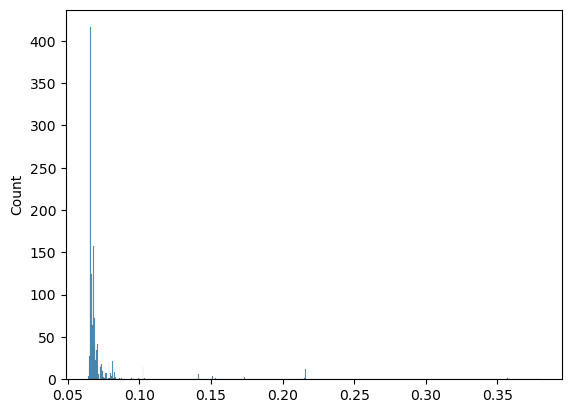

In [77]:
sns.histplot(preds)

In [78]:
import numpy as np

In [79]:
preds = np.array(preds)

In [80]:
labels = np.array(labels)

In [94]:
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score

In [121]:
ts = np.linspace(0.05, 0.1, 1000)
scores = []

In [122]:
preds>t

array([False, False, False, ..., False, False, False])

In [123]:
for t in ts:
    scores.append(f1_score(labels, preds>t))

In [124]:
ts[np.argmax(scores)]

0.06596596596596596

In [125]:
np.max(scores)

0.7162647511544381

In [127]:
# I had an idea why my previous model scored 95+% accuracy
# I scored 52% and after some investigation I changed multiclassficationevaluator to binary class evaluator
# and I just changed the metric from accuracy to ROC because accurace will not be representitive to a 
# non balanced data 

### After figuring out the threshold to be 0.06596596596596596 I will copy the cells from above because I am not good at machine learning.

In [136]:
preds

array([0.06594128, 0.07605417, 0.07340497, ..., 0.06703991, 0.06814792,
       0.06672296])

In [137]:
preds_2= np.where(preds>0.06596596596596596, 0,1)

In [140]:
len(preds_2[preds_2==1])

559

In [141]:
len(preds_2[preds_2==0])

1119

In [199]:
labels = labels.astype(float)
labels2= labels.tolist()
preds = preds.astype(float)
preds2= preds.tolist()
preds_2 = preds_2.astype(float)
preds_22= preds_2.tolist()

In [203]:
schema = StructType([
    StructField("actual_Labels", FloatType(), True),
    StructField("proba", FloatType(), True),
    StructField("predictions", FloatType(), True)])
data = [(x, y, z) for x, y, z in zip(labels2, preds2, preds_22)]

In [204]:
df_predictions = spark.createDataFrame(data, schema=schema)

In [205]:
type(df_predictions)

pyspark.sql.dataframe.DataFrame

In [206]:
df_predictions.show(4)

+-------------+-----------+-----------+
|actual_Labels|      proba|predictions|
+-------------+-----------+-----------+
|          0.0| 0.06594128|        1.0|
|          0.0| 0.07605417|        0.0|
|          0.0|0.073404975|        0.0|
|          1.0| 0.06890384|        0.0|
+-------------+-----------+-----------+
only showing top 4 rows



In [214]:
print("Predicted Pass:")
df_predictions.filter("predictions=0").show(20,False)
print(" ")
print("Predicted Fradulenet:")
df_predictions.filter("predictions=1").filter("actual_labels=1").show(20,False)

Predicted Pass:
+-------------+-----------+-----------+
|actual_Labels|proba      |predictions|
+-------------+-----------+-----------+
|0.0          |0.07605417 |0.0        |
|0.0          |0.073404975|0.0        |
|1.0          |0.06890384 |0.0        |
|1.0          |0.080926105|0.0        |
|1.0          |0.06671699 |0.0        |
|0.0          |0.06725772 |0.0        |
|1.0          |0.0690224  |0.0        |
|0.0          |0.06819179 |0.0        |
|0.0          |0.072792396|0.0        |
|1.0          |0.07362097 |0.0        |
|0.0          |0.06814878 |0.0        |
|1.0          |0.07055956 |0.0        |
|0.0          |0.06614049 |0.0        |
|0.0          |0.06824388 |0.0        |
|1.0          |0.06777128 |0.0        |
|0.0          |0.06789524 |0.0        |
|0.0          |0.06747132 |0.0        |
|1.0          |0.07605417 |0.0        |
|0.0          |0.06704059 |0.0        |
|0.0          |0.066325225|0.0        |
+-------------+-----------+-----------+
only showing top 20 rows

### The ROC is 72% but I'm not sure how bad is this code